In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# retrieve data
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn unicode to plain ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# read a file and split liens
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# build category_lines dictionary
category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/My Drive/AI_and_ML/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Russian', 'French', 'Dutch', 'Scottish', 'Japanese', 'German', 'Vietnamese', 'Spanish', 'Portuguese', 'Italian', 'Korean', 'Czech', 'Greek', 'Chinese', 'Arabic', 'English', 'Polish', 'Irish']
O'Neal


The RNN used to generate the words is defined below. It has 3 layers.

1. The first (input to hidden) computes the new hidden weights from the input state, category, and previous hidden state combined together.
2. The second layer (input to output) produces the output state from the input, category, and previous hidden state.
3. The third layer (output to output) refines the output from the concatenated result of the previous two layers, which are the hidden and output.

At the end, it also includes a dropout layer and softmax normalization.

In [14]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)

        self.dropout = nn.Dropout(0.1); # 10% dropout rate
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


Now, helper functions for training the network:

In [15]:
import random

# sample random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

# get a random category and line
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [51]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Then, the code to train the network is below:

In [52]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [53]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)

rnn = RNN(n_letters, 128, n_letters) # 128 hidden units, input and output are the number of possibilities for next letter

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 14s (5000 5%) 3.1826
0m 28s (10000 10%) 2.1885
0m 44s (15000 15%) 1.8627
1m 0s (20000 20%) 2.7002
1m 17s (25000 25%) 2.2111
1m 32s (30000 30%) 2.5843
1m 47s (35000 35%) 2.0613
2m 4s (40000 40%) 2.5187
2m 20s (45000 45%) 1.7247
2m 36s (50000 50%) 1.8769
2m 50s (55000 55%) 2.3004
3m 5s (60000 60%) 2.7374
3m 19s (65000 65%) 1.4752
3m 35s (70000 70%) 2.3625
3m 49s (75000 75%) 1.1692
4m 5s (80000 80%) 2.1620
4m 21s (85000 85%) 2.9157
4m 36s (90000 90%) 2.7046
4m 50s (95000 95%) 3.2794
5m 5s (100000 100%) 2.5484


To plot losses:

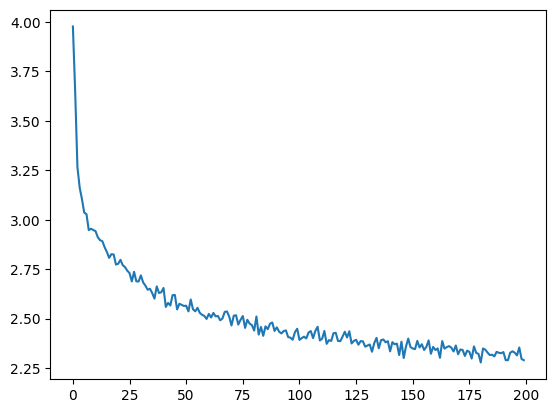

In [54]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

To try out some samples:

In [57]:
max_length = 20

# sample from a category, and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter

            input = inputTensor(letter)

        return output_name

# get various samples
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHX')

Rovakov
Uakien
Shilovev
Gerter
Ering
Rour
Salla
Para
Arane
Chan
Hou
Xue
